In [1]:
const λ = 1.0
const Z = 2.0
const _ordenTaylor = 20
const ɛ = 1.0e-20

1.0e-20

In [2]:
using Plots, TaylorSeries
pyplot(legend = :false)

Plots.PyPlotBackend()

In [3]:
# Returns stepsize of the integration and a vector with the updated values of the dependent
# variables
function taylorStepper{T<:Real}( jetEqs::Function, vec0::Array{T,1} )
    
    n = length( vec0 )

    vec0T = Array(Taylor1{T},n)
    @simd for i in eachindex(vec0)
        @inbounds vec0T[i] = Taylor1([vec0[i]], _ordenTaylor)
    end

    # Jets
    vec1T = jetEqs( vec0 )
    
    # Step-size
    hh = Inf
    for i in eachindex(vec1T)
        @inbounds h1 = stepsize( vec1T[i], ɛ )
        hh = min( hh, h1 )
    end
    
    # Values at t0+h
    @simd for i in eachindex(vec0)
        @inbounds vec0[i] = evaluate( vec1T[i], hh )
    end
    
    return hh, vec0
end

# Returns the maximum step size from epsilon and the last two coefficients of the x-Taylor series 
function stepsize{T<:Real}(x::Taylor1{T}, epsilon::Float64)
    ord = x.order
    h = Inf
    for k in [ord-1, ord]
        kinv = 1.0/k
        aux = abs( x.coeffs[k+1] )
        h = min(h, (epsilon/aux)^kinv)
    end
    return h
end

stepsize (generic function with 1 method)

Aquí implementaremos el hamiltoniano regularizado, con $E = -1$, debe cumplirse que $H = 0 \ \forall t$, primero, tomaremos una función auxiliar:

In [4]:
ks(Q) = Q^2

ks (generic function with 1 method)

In [5]:
function regHam(Q₁, Q₂, P₁, P₂)
    #Cantidades auxiliares
    P₁² = P₁^2
    P₂² = P₂^2
    Q₁² = Q₁^2
    Q₂² = Q₂^2
    nf = abs(ks(Q₁) - ks(Q₂))
    
    H = 0.125*(P₁²*Q₂² + P₂²*Q₁²) - Z*(Q₁² + Q₂²) + Q₁²*Q₂²*(1.0 + 1.0/nf)
    return H
end


regHam (generic function with 1 method)

Implementaremos también la función para regresar las velocidades al espacio fase de la configuración original... 

In [6]:
function ksv(Q, P)
    v₁ = (Q*P)
    return v₁
end

ksv (generic function with 1 method)

In [7]:
function jetundriven{T<:Real}( vec::Array{T,1} )

    tT = Taylor1(vec[1], _ordenTaylor)
    Q1T = Taylor1(vec[2], _ordenTaylor)
    P1T = Taylor1(vec[3], _ordenTaylor)
    Q2T = Taylor1(vec[4], _ordenTaylor)
    P2T = Taylor1(vec[5], _ordenTaylor)
    
    # Auxiliary quantities
    sQ1 = zeros( T, _ordenTaylor+1 )
    sP1 = zeros( T, _ordenTaylor+1 )
    sQ2 = zeros( T, _ordenTaylor+1 )
    sP2 = zeros( T, _ordenTaylor+1 )
    f1 = zeros( T, _ordenTaylor+1 )
    f12 = zeros( T, _ordenTaylor+1 )
    nfQ = zeros( T, _ordenTaylor+1 )
    rnfQ = zeros( T, _ordenTaylor+1 )
    n3fQ = zeros( T, _ordenTaylor+1 )
    n2Qs  = zeros( T, _ordenTaylor+1 )

    dotQ1 = zeros( T, _ordenTaylor+1 )
    dotP1 = zeros( T, _ordenTaylor+1 )
    dotQ2 = zeros( T, _ordenTaylor+1 )
    dotP2 = zeros( T, _ordenTaylor+1 )
    dott = zeros( T, _ordenTaylor+1 )
    
    s11P1 = zeros( T, _ordenTaylor+1 )
    s1P1 = zeros( T, _ordenTaylor+1 )
    P1d1 = zeros( T, _ordenTaylor+1 )
    s12P1 = zeros( T, _ordenTaylor+1 )
    s2m2P1 = zeros( T, _ordenTaylor+1 )
    P1d2 = zeros( T, _ordenTaylor+1 )
    s2P1 = zeros( T, _ordenTaylor+1 )
    
    
    s11P2 = zeros( T, _ordenTaylor+1 )
    P2d1 = zeros( T, _ordenTaylor+1 )
    s1P2 = zeros( T, _ordenTaylor+1 )
    s12P2 = zeros( T, _ordenTaylor+1 )
    s2m2P2 = zeros( T, _ordenTaylor+1 )
    P2d2 = zeros( T, _ordenTaylor+1 )
    s2P2 = zeros( T, _ordenTaylor+1 )
    
    # Now the implementation
    for k = 0:_ordenTaylor-1
        knext = k+1
        # The right-hand size of the eqs of motion
        # This is more adpated for this problem, and avoids many superflous operations
        #@show "That's ok"
        sQ1[knext] = TaylorSeries.squareHomogCoef(k, Q1T.coeffs)
        sP1[knext] = TaylorSeries.squareHomogCoef(k, P1T.coeffs)
        sQ2[knext] = TaylorSeries.squareHomogCoef(k, Q2T.coeffs)
        sP2[knext] = TaylorSeries.squareHomogCoef(k, P2T.coeffs)
        
        f1[knext] = sQ1[knext] - sQ2[knext]  
        f12[knext] = TaylorSeries.squareHomogCoef(k, f1)
        nfQ[knext] = TaylorSeries.powHomogCoef(k, f12, 0.5, nfQ, 0)
        n3fQ[knext] = TaylorSeries.powHomogCoef(k, f12, 1.5, n3fQ, 0)
        n2Qs[knext] = TaylorSeries.mulHomogCoef(k, sQ1, sQ2)
        
        P1d1[knext] = TaylorSeries.divHomogCoef(k, sQ2, nfQ, P1d1, 0)
        s11P1[knext] = -0.125*sP2[knext] + Z - P1d1[knext] - sQ2[knext]
        s1P1[knext] = 2.0*TaylorSeries.mulHomogCoef(k, Q1T.coeffs, s11P1)
        P1d2[knext] = TaylorSeries.divHomogCoef(k, f1, n3fQ, P1d2, 0)
        s2m2P1[knext] = 2*TaylorSeries.mulHomogCoef(k, P1d2, Q1T.coeffs)
        s2P1[knext] = TaylorSeries.mulHomogCoef(k, n2Qs, s2m2P1)
        
        
        
        P2d1[knext] = TaylorSeries.divHomogCoef(k, sQ1, nfQ, P2d1, 0)
        s11P2[knext] = -0.125*sP1[knext] + Z - P2d1[knext] - sQ1[knext]
        s1P2[knext] = 2.0*TaylorSeries.mulHomogCoef(k, Q2T.coeffs, s11P2)
        s2m2P2[knext] = -2*TaylorSeries.mulHomogCoef(k, P1d2, Q2T.coeffs)
        s2P2[knext] = TaylorSeries.mulHomogCoef(k, n2Qs, s2m2P2)
        
    
        dotQ1[knext] = 0.25*TaylorSeries.mulHomogCoef(k,sQ2, P1T.coeffs)
        dotP1[knext] = s1P1[knext] + s2P1[knext]
        dotQ2[knext] = 0.25*TaylorSeries.mulHomogCoef(k,sQ1, P2T.coeffs)        
        dotP2[knext] = s1P2[knext] + s2P2[knext]             
        dott[knext] = n2Qs[knext]
        
        #@show "That's ok"
        Q1T.coeffs[knext + 1] = dotQ1[knext]/knext        
        P1T.coeffs[knext + 1] = dotP1[knext]/knext        
        Q2T.coeffs[knext + 1] = dotQ2[knext]/knext        
        P2T.coeffs[knext + 1] = dotP2[knext]/knext        
        tT.coeffs[knext + 1] = dott[knext]/knext
    end
    
    return Taylor1[tT, Q1T, P1T, Q2T, P2T]
end

jetundriven (generic function with 1 method)

In [8]:
#Creamos condiciones iniciales
function condini(x10::Float64, px10::Float64)
    @assert x10 != 0
    Q1 = sqrt(x10)
    Q2 = 0.0
    P1 = px10*sqrt(x10)    
    P2 = sqrt(8Z)    
    return Q1, Q2, P1, P2
end

condini (generic function with 1 method)

In [9]:
function undrivenIntegration(x10::Float64, px10::Float64, time_max::Float64, jetEqs::Function )
    
    Q₁, Q₂, P₁, P₂ = condini(x10, px10)
    τ₀ = 0.0
    t0 = 0.0
    
    ene0 = regHam(Q₁, Q₂, P₁, P₂)
        
    Q1v, Q2v, P1v, P2v = Float64[], Float64[], Float64[], Float64[]
    tv, τv = Float64[], Float64[]
    DeneV= Float64[]
    push!(tv, t0)
    push!(τv, τ₀)
    push!(Q1v, Q₁)
    push!(P1v, P₁)
    push!(Q2v, Q₂)
    push!(P2v, P₂)
       
    push!(DeneV, ene0)
    
    # This is the main loop; we include a minimum step size for security
    dτ = 1.0e-7
    while τ₀ < time_max && dτ>1.0e-8
        #Preparamos el vector para integrar
        temp1 = Float64[t0, Q₁ , Q₂, P₁, P₂]
        # Here we integrate
        dτ, (t, Q1, P1, Q2, P2) = taylorStepper( jetEqs, temp1);
        
        τ₀ += dτ
        push!(tv, t)
        push!(τv, τ₀)
        push!(Q1v, Q1)        
        push!(P1v, P1)        
        push!(Q2v, Q2)        
        push!(P2v, P2)
        eneEnd = regHam(Q1, P1, Q2, P2)
        
        dEne = abs(eneEnd - ene0)
        
        push!(DeneV, dEne)
        t0, Q₁ , Q₂, P₁, P₂ = copy(t), copy(Q1), copy(Q2), copy(P1), copy(P2)
    end

    return τv, tv, Q1v, P1v, Q2v, P2v, DeneV
end

undrivenIntegration (generic function with 1 method)

Para la configuración de $Zee$ en 1D necesitamos que $y_1, y_2 = 0$; $p_{y_1}, p_{y_2} = 0$, además, necesitamos la condición de que la partícula 2 colisione con el núcleo, por lo que $x_2 = 0$ sobre las coordenadas $(\mathbf{P}, \mathbf{Q})$ implican que:

\begin{align}
    x_1 = x_{1_0} &\Leftrightarrow Q_{11}^2 - Q_{12}^2 = x_{1_0}\\
    y_1 = 0 &\Leftrightarrow 2Q_{11}Q_{12} = 0\\
    x_2 = 0 &\Leftrightarrow Q_{21}^2 - Q_{22}^2 = x_{2_0}\\
    y_2 = 0 &\Leftrightarrow 2Q_{21}Q_{22} = 0 \\
    p_{x_1} = px_{1_0} &\Leftrightarrow Q_{11}P_{11} - Q_{12}P_{12} = px_{1_0}\\
    p_{y_1} = 0 &\Leftrightarrow Q_{12}P_{11} + Q_{11}P_{12} = 0\\
    p_{x_2} = px_{2_0} &\Leftrightarrow Q_{21}P_{21} - Q_{22}P_{22} = px_{2_0}\\
    p_{y_2} = 0 &\Leftrightarrow Q_{22}P_{21} + Q_{21}P_{22} = 0
\end{align}


A partir de esto, podemos concluir que:

\begin{align}
    Q_{11} &= \sqrt{x_{1_0}}\\
    Q_{12} &= 0\\
    Q_{21} &= 0\\
    Q_{22} &= 0\\
    P_{11} &= \frac{px_{1_0}}{Q_{11}}\\
    P_{12} &= 0\\
    P_{22} &= 0
\end{align}

Para las condiciones sobre los momento $P_{21} = 0$ de la partícula 2, debemos considerar la condición sobre la energía del sistema (considerando el hamiltoniano regularizado $H^{SC}$), pues recordemos que se debe cumplir que $H = 0$. Usando las condiciones ya encontradas se halla que debe cumplirse que $|P_2|^2 = Z = 2$, entonces:

\begin{align}
    Q_{11} &= \sqrt{x_{1_0}}\\
    Q_{12} &= 0\\
    Q_{21} &= 0\\
    Q_{22} &= 0\\
    P_{11} &= p_{x_{1}}\sqrt{x_{1_0}}\\
    P_{12} &= 0\\
    P_{21} &= 2\sqrt{2Z}\\
    P_{22} &= 0
\end{align}


In [10]:
@time tv, τv, Q1v, P1v, Q2v, P2v, DeneV = undrivenIntegration(5.1, 1.4, 2.5, jetundriven);

  0.284844 seconds (203.04 k allocations: 10.145 MB)


In [11]:
Q1v

207-element Array{Float64,1}:
  2.25832  
  2.25025  
  2.2589   
  2.24145  
  2.26017  
  2.23424  
  2.25363  
  2.21953  
  2.2284   
  2.17549  
  2.19079  
  2.14649  
  2.19306  
  ⋮        
 -0.62883  
 -0.320857 
 -0.0153443
  0.304758 
  0.615655 
  0.907711 
  1.16265  
  1.37487  
  1.54253  
  1.68562  
  1.78254  
  1.87611  

In [12]:
DeneV

207-element Array{Float64,1}:
  0.0    
  1.52258
 42.2585 
  5.76539
 43.1357 
 13.6379 
 44.1911 
 34.0324 
 47.3923 
 46.0922 
 42.7969 
 42.7811 
 47.3654 
  ⋮      
 16.3879 
 26.356  
 14.0623 
 27.2972 
 20.1081 
 29.8789 
 27.5555 
 28.6573 
 29.8968 
 24.3299 
 28.2128 
 26.5335 


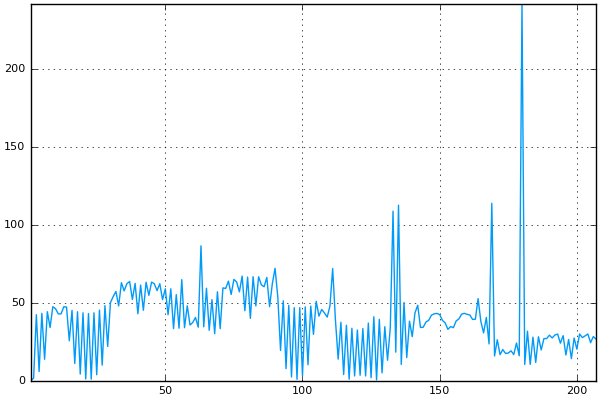

In [13]:
plot(eachindex(DeneV), DeneV)

In [17]:
#Con esto regreso al espacio de configuración inicial
x1 = map(ks, Q1v)
vx1 = Float64[ksv(Q1v[j], P1v[j]) for j in eachindex(Q1v)];


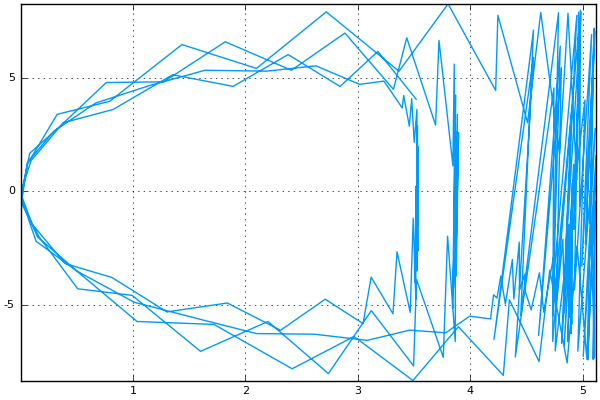

In [18]:
plot(x1,vx1)